

- Nama Lengkap : Adisaputra Zidha Noorizki
- Username : hi_zidha
- Email : hi.zidha@gmail.com



In [ ]:
!pip install tensorflow
!pip install keras

# Dataset: https://www.kaggle.com/datasets/marquis03/bdd100k-weather-classification

Import Dataset

In [ ]:
!pip install split-folders

In [ ]:
import os, shutil, zipfile, splitfolders
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/MyDrive/Colab Notebooks/IDCamp2023/Intermediate/dataset/dataset.zip"
extracted_path = "/content/drive/MyDrive/Colab Notebooks/IDCamp2023/Intermediate/dataset/datasetIntermediate"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

extracted_path += "/dataset"
ready_dataset_path = "/content/drive/MyDrive/Colab Notebooks/IDCamp2023/Intermediate/dataset/datasetIntermediate/readyDataset"
os.makedirs(ready_dataset_path, exist_ok=True)

subfolders = ['overcast', 'partly cloudy', 'rainy', 'snowy']
target_file_count = 2600

for subfolder in subfolders:
    source_folder = os.path.join(extracted_path, subfolder)
    target_folder = os.path.join(ready_dataset_path, subfolder)

    os.makedirs(target_folder, exist_ok=True)
    files = os.listdir(source_folder)
    selected_files = files[:target_file_count]

    for file_name in selected_files:
        source_path = os.path.join(source_folder, file_name)
        target_path = os.path.join(target_folder, file_name)
        shutil.move(source_path, target_path)

print("Proses selesai.")

input_folder = ready_dataset_path
output_folder = '/content/drive/MyDrive/Colab Notebooks/IDCamp2023/Intermediate/dataset/datasetIntermediate/finalDataset'

splitfolders.ratio(input_folder,
                   output_folder,
                   seed=42,
                   ratio=(0.8, 0.2))

train_dir = output_folder+'/train'
val_dir   = output_folder+'/val'

In [ ]:
import tensorflow as tf
import keras
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import Accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

Pre-processing Data

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

validation_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 8320 images belonging to 4 classes.
Found 2080 images belonging to 4 classes.


Build a Model

In [ ]:
batch_size = 128
input_shape = (224, 224, 3)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('weatherClassification.h5', save_best_only=True, mode='max')
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

model = Sequential([
    Input(shape=input_shape),

    Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(512, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(512, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(512, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dropout(0.25),
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
], name='modelCNN')

model.summary()

Model: "modelCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 28, 28, 256)       0  

Setting and Compile Model

In [ ]:
optimizers = Adam(learning_rate=0.001)
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    steps_per_epoch=48,
    validation_data=validation_gen,
    validation_steps=16,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]
)

Epoch 1/50
 9/48 [====>.........................] - ETA: 34:03 - loss: 1.4148 - accuracy: 0.3116

In [ ]:
model.save("weatherClassification.h5", include_optimizer=True)

Plotting the model accuracy and loss

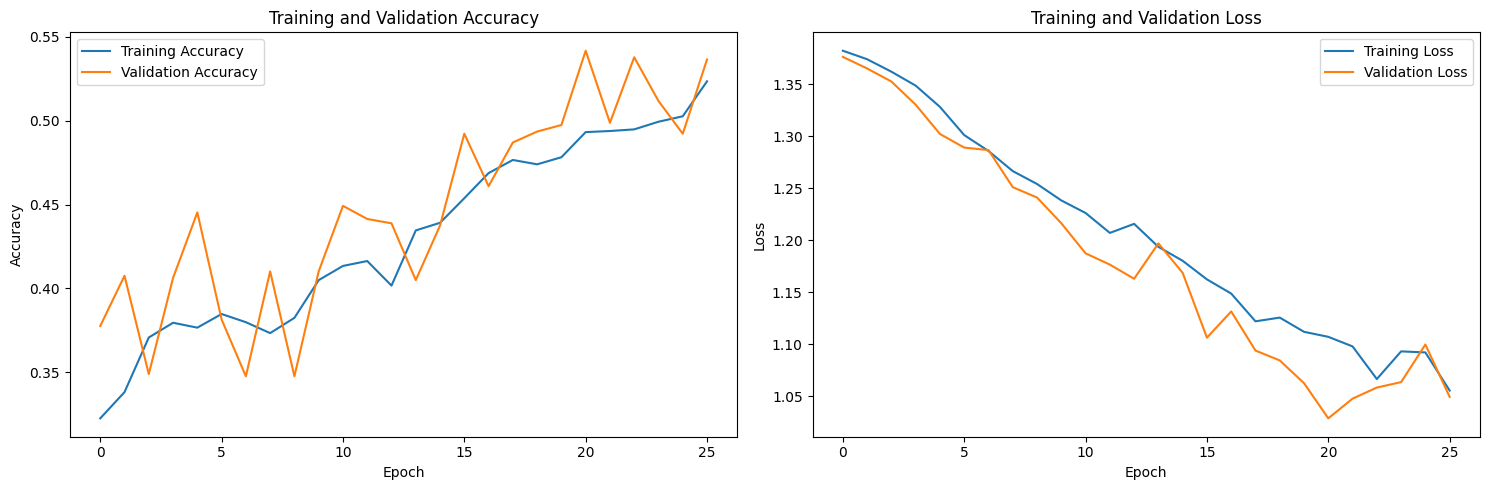

In [ ]:
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

Convert Model format from '.h5' to TF-Lite

In [ ]:
models = tf.keras.models.load_model('weatherClassification.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(models)
tflite_model = converter.convert()

with open('weatherModels.tflite', 'wb') as f:
    f.write(tflite_model)